In [4]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import confusion_matrix
from tempfile import TemporaryDirectory

In [15]:


class CNN(nn.Module):
    """Convolutional Neural Network model for image classification."""
    
    def __init__(self, base_model, num_classes, unfreezed_layers=0):
        """CNN model initializer."""
        super().__init__()
        self.base_model = base_model
        self.num_classes = num_classes

        # Freeze convolutional layers
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Unfreeze specified number of layers
        if unfreezed_layers > 0:
            children = list(self.base_model.children())
            for child in children[-unfreezed_layers:]:
                for param in child.parameters():
                    param.requires_grad = True

        # Modify the classifier to match the number of classes
        in_features = self.base_model.classifier[-1].in_features
        self.base_model.classifier[-1] = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        """Forward pass of the model."""
        x = self.base_model(x)
        return x

    def train_model(self, train_loader, valid_loader, optimizer, criterion, epochs, nepochs_to_save=10, start_epoch=0):
        """Train the model, save checkpoints, and output training and validation metrics."""
        for epoch in range(epochs):
            self.train()
            train_loss = train_accuracy = 0.0
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = self(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_accuracy += (outputs.argmax(1) == labels).sum().item()

            train_loss /= len(train_loader)
            train_accuracy /= len(train_loader.dataset)

            # Evaluate on validation set
            self.eval()
            valid_loss = valid_accuracy = 0.0
            with torch.no_grad():
                for images, labels in valid_loader:
                    outputs = self(images)
                    loss = criterion(outputs, labels)
                    valid_loss += loss.item()
                    valid_accuracy += (outputs.argmax(1) == labels).sum().item()

            valid_loss /= len(valid_loader)
            valid_accuracy /= len(valid_loader.dataset)

            print(f'Epoch {start_epoch + epoch + 1}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
                  f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}')
            
            if (epoch + 1) % nepochs_to_save == 0:
                checkpoint_path = f'./models/cnn_checkpoint_epoch_{start_epoch + epoch + 1}.pt'
                torch.save(self.state_dict(), checkpoint_path)
                print(f'Saved checkpoint to {checkpoint_path}')

# Usage example
train_loader, valid_loader, num_classes = load_data('./dataML/dataset/training', './dataML/dataset/validation', batch_size=32, img_size=224)
base_model = torchvision.models.mobilenet_v3_large(pretrained=True)
model = CNN(base_model, num_classes, unfreezed_layers=2)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Start a fresh training session or continue from the last epoch count
start_epoch = 0  # Set this to the last epoch from the previous session if continuing training
epochs_to_train = 50
model.train_model(train_loader, valid_loader, optimizer, criterion, epochs=epochs_to_train, nepochs_to_save=10, start_epoch=start_epoch)

Epoch 1: Train Loss: 2.1398, Train Acc: 0.3755, Valid Loss: 1.5737, Valid Acc: 0.6240
Epoch 2: Train Loss: 1.3205, Train Acc: 0.6673, Valid Loss: 1.0604, Valid Acc: 0.6787
Epoch 3: Train Loss: 0.9727, Train Acc: 0.7219, Valid Loss: 0.8194, Valid Acc: 0.7413
Epoch 4: Train Loss: 0.8234, Train Acc: 0.7585, Valid Loss: 0.7022, Valid Acc: 0.7567
Epoch 5: Train Loss: 0.7347, Train Acc: 0.7712, Valid Loss: 0.5908, Valid Acc: 0.7787
Epoch 6: Train Loss: 0.7406, Train Acc: 0.7501, Valid Loss: 0.5379, Valid Acc: 0.8087
Epoch 7: Train Loss: 0.6702, Train Acc: 0.7826, Valid Loss: 0.5090, Valid Acc: 0.8007
Epoch 8: Train Loss: 0.6426, Train Acc: 0.7896, Valid Loss: 0.4417, Valid Acc: 0.8333
Epoch 9: Train Loss: 0.6369, Train Acc: 0.7987, Valid Loss: 0.4404, Valid Acc: 0.8313
Epoch 10: Train Loss: 0.6219, Train Acc: 0.7883, Valid Loss: 0.3824, Valid Acc: 0.8613
Saved checkpoint to ./models/cnn_checkpoint_epoch_10.pt
Epoch 11: Train Loss: 0.6140, Train Acc: 0.7963, Valid Loss: 0.3425, Valid Acc: 0.8

In [17]:
current_epoch = 50  
checkpoint_path = f'./models/cnn_final_epoch_{current_epoch}.pt'
torch.save({
    'epoch': current_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, checkpoint_path)

print(f'Saved checkpoint to {checkpoint_path}')

Saved checkpoint to ./models/cnn_final_epoch_50.pt


In [18]:


def load_model(checkpoint_path, num_classes):
    """ Load the saved model from a checkpoint. """
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path)

    # Reinitialize the model with the correct number of classes
    base_model = torchvision.models.mobilenet_v3_large(weights=None)  # Load without pretrained weights
    model = CNN(base_model, num_classes, unfreezed_layers=2)

    # Load the saved state dictionary into the model
    model.load_state_dict(checkpoint['model_state_dict'])

    return model

def evaluate_model(model, data_loader):
    """ Evaluate the model accuracy on a provided data loader """
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

# Load the model
num_classes = 15  # Ensure this matches the number of classes the model was trained on
checkpoint_path = './models/cnn_final_epoch_50.pt'
model = load_model(checkpoint_path, num_classes)

accuracy = evaluate_model(model, valid_loader)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

Validation Accuracy: 89.07%


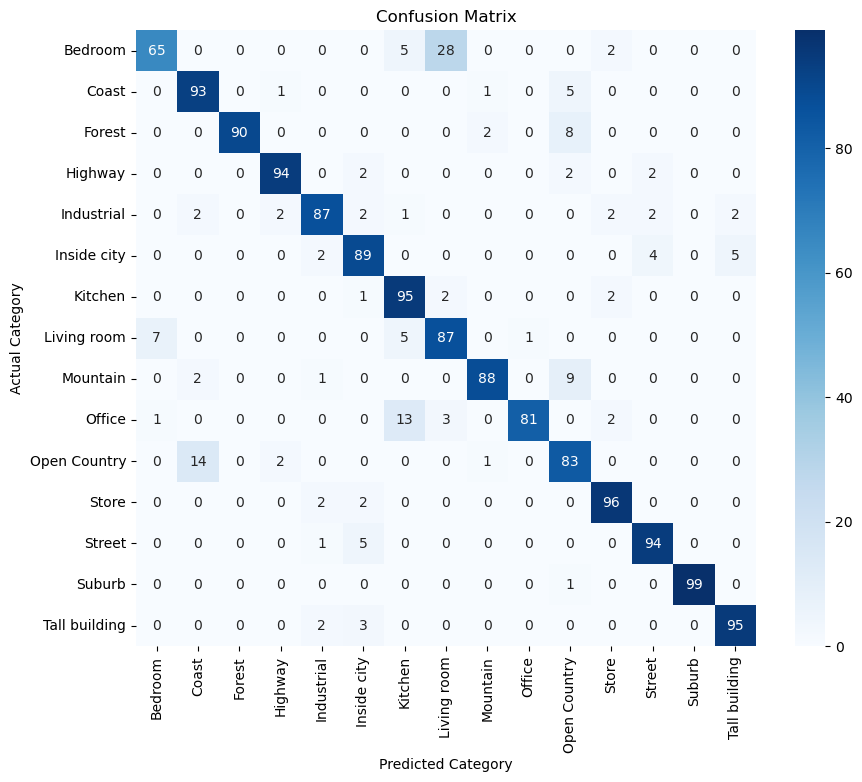

In [20]:

num_classes = 15  # This should match the number of categories
checkpoint_path = './models/cnn_final_epoch_50.pt'
model = load_model(checkpoint_path, num_classes)

# Setup the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Assuming valid_loader is already set up correctly
actual_labels = []
predicted_labels = []

# Evaluate the model to get predictions
model.eval()
with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        actual_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Define category names for better visualization
category_names = [
    'Bedroom', 'Coast', 'Forest', 'Highway', 'Industrial',
    'Inside city', 'Kitchen', 'Living room', 'Mountain', 'Office',
    'Open Country', 'Store', 'Street', 'Suburb', 'Tall building'
]

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.show()